In [1]:
#our goal is to have top K artist recommendations for a user, so that they would 
from math import log
from __future__ import print_function
import pandas as pd
import implicit
import numpy as np
import scipy
import random
from operator import itemgetter
from tqdm import tqdm_notebook as tqdm

df = pd.read_csv('lastfm_9000_users.csv', na_filter=False)
df = df.drop(['Unnamed: 0'], axis=1)

## TO DO

BIG THINGS: 
- set-up cross-validation
    - Baseline model evaluate
    - Tune our Hyperparameters
- fix precision/recall
- calculate NDCG  
- seeing if it scales

CASES TO EVALUATE:
- sparse vs. non-sparse data
- threshold of relevance
- which users should we hold out (those with > 10/20/30 values?)

PERFORMANCE:
- speed up split_train_per_user, by figuring out how to access zero values faster
- speed up precision, recall evaluation

## Data Preparation|

In [2]:
#create sparse matrix from dataframe object
def create_sparse_matrix(data, user_user = True):
    """
    Creates sparse matrix (csr_matrix) out of pandas dataframe.
    
    Parameters: 
    - data: Dataframe of user/artist data
    - user_user: determines whether output will be for user-to-user or item-to-item collaborative filtering
                 if user_user is True, then rows will be items and columns will be users
    
    Returns: 
    - plays_sparse: a sparse csr_matrix
    
    """
    print("Creating sparse matrix...")
    #grab unique users/artist IDS
    users = list(np.sort(data.user_id.unique()))
    artists = list(data.artist_mbid.unique())
    plays = list(data.plays)

    # user-user set-up
    if (user_user == True):
        rows = data.user_id.astype('category', categories=users).cat.codes
        cols = data.artist_mbid.astype('category', categories=artists).cat.codes
        plays_sparse = scipy.sparse.csr_matrix((plays, (rows, cols)), shape=(len(users),len(artists)))

    #item-item set-up
    else:    
        rows = data.artist_mbid.astype('category', categories=artists).cat.codes
        cols = data.user_id.astype('category', categories=users).cat.codes
        plays_sparse = scipy.sparse.csr_matrix((plays, (rows, cols)), shape=(len(artists),len(users)))
        
    return plays_sparse

In [3]:
#calculate how sparse the matrix is
def calculate_sparsity(M):
    """
    Calculates how sparse this matrix
    """
    matrix_size = float(M.shape[0]*M.shape[1]) # Number of possible interactions in the matrix
    num_plays = len(M.nonzero()[0]) # Number of items interacted with
    sparsity = 100*(1 - float(num_plays/matrix_size))
    return sparsity

## Split Train Test

In [4]:
#split train, test using all user pairs
def make_train_all_user_pairs(data, test_pct):
    """
    params:
        data: data set in csr_matrix format
        test_pct: percentage to be test set
    """
    #create copies of dataset for training and test data
    test = data.copy()
    train = data.copy()
    
    #alter train data, masking/holding-out random user-pair values for some users
    nonzero_idx = train.nonzero() #find indices in data where interaction exists
    
    
    nonzero_pairs = zip(nonzero_idx[0], nonzero_idx[1]) #create pairs of (user, item) index
    
    #determine how many user-pair values we need to mask, according to test_pct
    random.seed(0) #for reproducibility
    num_samples = int(np.ceil(test_pct * len(nonzero_pairs)))
    samples = random.sample(nonzero_pairs, num_samples) #sample random number of user-item pairs without replacement
    print(type(samples))
    #get user, item row and column indices
    user_idx = [index[0] for index in samples] 
    item_idx = [index[1] for index in samples] 
    
    train[user_idx,item_idx] = 0 #mask the randomly chosen user-item pairs
    train.eliminate_zeros() #remove zeros in sparse arrays that was made previously
    
    return train, test, list(set(user_idx)), samples #output unique list of user rows that were altered

In [5]:
#split train, test by user only with interactions#, with test size=total/k
def split_train_test_per_user(data, k, interactions = 20,cross_valid= False):
    """
    Create train matrix with masked values and dictionary of test values 
    
    Parameters:
    - data: csr_matrix, assuming matrix is user-user (item as rows, columns as users)
    - test_pct: percentage of items to mask per user
    
    Output:
    - train: masked matrix
    - test: list of tuples of held out data ((user_idx, item_idx), plays)
    """
    random.seed(0) #for reproducibility
    
    train = data.copy() #transpose to make procedure easier/more intuitive
    
    test = dict() #dict to keep track of masked user-item values
    
    user_count = 0
    test_list=[]
    train_list=[]
    if cross_valid==True: #initialize
        for i in range(k):
            test_list.append(dict())
            train_list.append(train)
    
    #for each user in the training set
    for user_idx in tqdm(range(train.get_shape()[0])):

        #get indices of interactions of this user
        nonzero_idx = train[user_idx].nonzero()

        #only hold out users that have enough data (greater than interactions #)
        if nonzero_idx[1].shape[0] >= interactions:
            user_count += 1
            #create list of tuples: interaction index (row, col) with the number of plays
            nonzero_pairs = [((user_idx, item_idx), train[user_idx,item_idx]) for item_idx in nonzero_idx[1]]

            #sort tuples descending by value
            nonzero_sorted = sorted(nonzero_pairs, key = itemgetter(1), reverse = True)

            #get top interaction # values, then sample test_pct% randomly from subset
            top_values = nonzero_sorted[0:interactions]

            #sample random number of item_indexes without replacement
            num_samples = int(np.floor(interactions/float(k)))
            if (cross_valid==False): 
                samples = random.sample(top_values, num_samples) 

                #append user_idx, item_
                test[user_idx] = [pair[0][1] for pair in samples]

                #mask the randomly chosen items of this user
                for pair in samples:
                    train[pair[0][0], pair[0][1]] = 0

            else: #Cross Validation Step
                for i in range(k):
                    train = train_list[i]
                    k_test=test_list[i]
                    random.shuffle(top_values) 
                    samples=top_values[0:num_samples]
                    top_values=top_values[num_samples:]
                    #append user_idx, item_
                    k_test[user_idx] = [pair[0][1] for pair in samples]
                    test_list[i]=k_test #update test
                    #mask the randomly chosen items of this user
                    for pair in samples:
                        train[pair[0][0], pair[0][1]] = 0
                    train.eliminate_zeros()
                    train_list[i]=train #update train
    if (cross_valid==False):
        return train.T.tocsr(), test, user_count #convert matrix back
    else:
        for i in range(k):
            train_list[i]=train_list[i].T.tocsr()
        return train_list, test_list, user_count #convert matrix back


In [6]:
#calculate how many interactions are masked compared to previous dataset
def pct_masked(original, altered):
    altered_n = altered.nonzero()[0].shape[0]
    original_n = original.nonzero()[0].shape[0]
    return (original_n - altered_n)/float(altered_n)

## Custom Models

In [7]:
def baseline(k,user_items):
    plays=user_items.toarray()
    totalplays=np.sum(plays,axis=1)    
    idx = (-totalplays).argsort()[:k]
    return idx

## Evaluation/Metrics

In [8]:
def zeros_list(n):
    listofzeros = [0] * n
    return listofzeros

def dcg_at_k(scores):
    assert scores
    return scores[0] + sum(sc / log(ind, 2) for sc, ind in zip(scores[1:], range(2, len(scores)+1)))

def ndcg_at_k(predicted_scores, user_scores):
    """
    predicted_scores: recommended k items from model
    user_scores: held out items
    """
    assert len(predicted_scores) == len(user_scores)

    idcg = dcg_at_k(sorted(user_scores, reverse=True))
    x = (dcg_at_k(predicted_scores) / idcg) if idcg > 0.0 else 0.0
    
    return x

#used to evaluate model
def evaluate(model, test, M, n_rec = 20):
    """
    Calculate precision/recall
    
    parameters:
    - model: fitted implicit model that will perform recommendations
    - test: list containing tuples that are heldout for each user
    - M: csr_matrix of item-users, used in fit
    - n_rec: how many recommendations the system outputs
    
    
    returns:
    - two numpy arrays containing precision and recall
    """
    #TODO: Refactor NDCG and Recall, less dependent on each other
    
    M_rec = M.T.tocsr() #transpose to recommend
    
    tp = float(0)
    test_n = float(0)
    print('Evaluating model...')
    
    ndcg = list()
    #calculate true positives for each user, append results to list
    for user, holdout_items in tqdm(test.items()):
        
        #get list of item recs for each user
        rec = model.recommend(user, M_rec, N=n_rec, filter_already_liked_items=True) #returns (item_id, score)
        rec_items = [pair[0] for pair in rec] #get only item_id
        test_n += len(holdout_items) #total number of heldout items
        
        #for NDCG
        predicted_scores = zeros_list(n_rec)
        user_scores = zeros_list(n_rec)
        i = 0
            
        #count true positives in recommended items
        for item in holdout_items: 
            value = M[user,item]
            user_scores[i] = value
            i += 1
            if item in rec_items:
                predicted_scores[rec_items.index(item)] = value #if holdout items is in recommended
                tp += 1
        #Calculate NDCG
        ndcg.append(ndcg_at_k(predicted_scores, user_scores))

    recall = tp/test_n
    return recall, np.mean(ndcg)

In [9]:
#used to evaluate model
def evaluate_base(rec_items, test, M, n_rec = 20):
    """
    Calculate recall
    
    parameters:
    - model: fitted implicit model that will perform recommendations
    - test: list containing tuples that are heldout for each user
    - M: csr_matrix of item-users, used in fit
    - n_rec: how many recommendations the system outputs
    returns:
    - numpy array containing recall
    """
    M_rec = M.T.tocsr() #transpose to recommend
    
    tp = float(0)
    test_n = float(0)
    rec_items = list(rec_items)
    ndcg = list()

    print('Evaluating model...')
    #calculate true positives for each user, append results to list

    for user, holdout_items in tqdm(test.items()):
        test_n += len(holdout_items)
        #count true positives in recommended items
        predicted_scores = zeros_list(n_rec)
        user_scores = zeros_list(n_rec)
        i = 0
        for item in holdout_items:
            value = M[user,item]
            user_scores[i] = value
            i += 1
            if item in rec_items:
                predicted_scores[rec_items.index(item)] = value #if holdout items is in recommended
                tp += 1

        ndcg.append(ndcg_at_k(predicted_scores, user_scores))
        
    recall = tp/test_n
    return recall,np.mean(ndcg)

# Main Script

#### Create sparse matrix

In [10]:
"""
PREPARE
"""
#create sparse matrix
plays_sparse = create_sparse_matrix(df).astype('float')

#filter out users with < 15 artists/reduce sparsity if needed
print('Matrix Sparsity:', calculate_sparsity(plays_sparse))

"""
SPLIT TRAIN TEST
"""
train, test, user_count = split_train_test_per_user(plays_sparse, 3, 10)
print("Percentage of original data masked:", pct_masked(plays_sparse, train))
print("Users masked:", user_count)

Creating sparse matrix...


C:\Users\Fernando\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
C:\Users\Fernando\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


Matrix Sparsity: 99.8965986346416



Percentage of original data masked: 0.06548419166887459
Users masked: 8980


#### Model-Based (ALS)

In [232]:
model = implicit.als.AlternatingLeastSquares(50)

# Train Model
print("Fitting model...")
model.fit(train, show_progress=True)

recall, ndcg = evaluate(model, test, plays_sparse)
print("Recall:",recall*100,'%')

<generator object <genexpr> at 0x116dfb0a0>
---
30
1
Fitting model...
Recall: 15.256137204349288 %
Average NDCG: 8.869369269177547 %


#### K-Nearest Neighbors (Item-Based)

In [ ]:
model_knn = implicit.nearest_neighbours.BM25Recommender()

# Train Model
print("Fitting model...")
model_knn.fit(train, show_progress=True)

recall, ndcg = evaluate(model_knn, test, plays_sparse)
print("Recall:",recall*100,'%')
print("Average NDCG:",ndcg*100,'%')

#### Run Baseline once

In [206]:
#BASELINE
user_items = plays_sparse.T.tocsr()
rec_items=baseline(20,user_items)

In [207]:
#Evaluate Baseline
recall,ndcg = evaluate_base(rec_items,test,plays_sparse)
print(recall*100,'%')
print("Average NDCG per User:",ndcg*100,'%')

Evaluating model...


7.939866369710467 %
Average NDCG per User: 4.783246758217563 %


# Cross Validation 

### Splitting into test and training sets

In [208]:
#Cross Validation test
k=5
train_list, test_list, user_count = split_train_test_per_user(plays_sparse,k,20,cross_valid=True)

### KNN/ALS Hyperparameter Tuning

In [11]:
"""
input: 
    - k: # of folds within the training set (split into tuning sets)
    - interactions: size of recommendation list
    - model: model that is being optimized   
    - data: sparse user-item matrix
    - param1: list of values to try for hyperparameter 1.
    - param2: list of values to try for hyperparameter 2. 
    - param3: list of values to try for hyperparameter 3.
    NOTE: if using KNN, there are 3 parameters. param2 is the integer used for k1; 
    only k and b are tested only param1 and param3 should be lists.
    If using ALS, there are 2 parameters. both should be lists. 
    
output:
    - max_ndcg_list: a list of k tuples, one for each fold. 
        each tuple is in the form (max_ndcg,max_first_param,max_second_param,max_recall)
        which records the best ndcg, and the two params that achieved it, 
        and the max_recall achieved (which may be from different param values).
"""
def auto_tune_parameter(k,interactions,model,data,param1,param2,param3=None):
    # train model
    #create list of MAX NDCG and Recall depending on # params
    max_ndcg_list=[] #will end up being length k list of tuples of best param values
    heatmap_list=[]
    if param3==None: #for ALS
        num_param=2
        first_param=param1
        second_param=param2
    else: #for KNN
        num_param=3
        first_param=param1
        second_param=param3
    train_and_tune,test,user_count=split_train_test_per_user(data, k+1, interactions,cross_valid= False)
    train_list, tune_list, user_count = split_train_test_per_user(train_and_tune.T.tocsr(),k,int(np.ceil(((k-1)/k)*interactions)),cross_valid=True)
    #to be updated via max: to determine final params to use on test set 
    test_ndcg=0
    test_first_param=first_param[0]
    test_second_param=second_param[0]
    #create recall/NDCG matrix storing for each combination of 
    for fold in range(k): #For each fold; there are k-1 folds within train_and_tune
        ndcg_heatmap=[[0 for x in range(len(second_param))] for y in range(len(first_param))]
        print(ndcg_heatmap)
        train=train_list[fold]
        tune=tune_list[fold]
        #not keeping track of individual ndcg for now ^^^
        max_first_param=first_param[0] #initialize best value of first_param for this fold
        max_second_param=second_param[0] #initialize best value of second_param for this fold
        max_recall=0
        max_ndcg=0
        value1_index=0 #index for heatmap
        print("Fitting fold number...",fold)
        for value1 in first_param:
            value2_index=0
            for value2 in second_param:
                if num_param==2:
                    print("Trying ",(value1,value2))
                    usemodel=model(value1,value2)
                if num_param==3:
                    print("Trying ",(value1,param2,value2))
                    usemodel=model(value1,param2,value2)
                usemodel.fit(train, show_progress=False)
                recall,ndcg = evaluate(usemodel,tune,data)
                print(value1_index,value2_index)
                ndcg_heatmap[value1_index][value2_index]=ndcg #update heatmap 
                #recall_list.append(recall)
                #update maximum values
                max_recall=max(max_recall,recall)
                if ndcg>max_ndcg: 
                    max_ndcg=ndcg
                    max_first_param=value1
                    max_second_param=value2
                value2_index=value2_index+1
            value1_index=value1_index+1    
        max_ndcg_list.append([max_ndcg,max_first_param,max_second_param,max_recall])
        if max_ndcg>test_ndcg:
            print("Fold ",fold," beat the record for ncdg!")
            print("New best ndcg is ",max_ndcg)
            print("New best params are ",(max_first_param,max_second_param))
            test_ndcg=max_ndcg
            test_first_param=max_first_param
            test_second_param=max_second_param
        heatmap_list.append(ndcg_heatmap)
        print("end of fold---------------------------")

    #Now, test_first_param and test_second_param should be optimized
    if num_param==2:
        usemodel=model(test_first_param,test_second_param)
    if num_param==3:
        usemodel=model(test_first_param,param2,test_second_param)
    usemodel.fit(train_and_tune,show_progress=True)
    final_recall,final_ndcg = evaluate(usemodel,test,data)
    
    print("The recall on the test set is ", final_recall,", after hyperparameter optimization")
    print("The ndcg on the test set is ",final_ndcg,", after hyperparameter optimization")
    
    return max_ndcg_list,heatmap_list 

In [12]:
model=implicit.nearest_neighbours.BM25Recommender
max_ndcg_list, heatmap_list = auto_tune_parameter(4,20,model,plays_sparse,[200,400,600,800,1000],1.2,[0,0.5,1])


[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
Fitting fold number... 0
Trying  (200, 1.2, 0)
Evaluating model...



0 0
Trying  (200, 1.2, 0.5)
Evaluating model...



0 1
Trying  (200, 1.2, 1)
Evaluating model...



0 2
Trying  (400, 1.2, 0)
Evaluating model...



1 0
Trying  (400, 1.2, 0.5)
Evaluating model...



1 1
Trying  (400, 1.2, 1)
Evaluating model...



1 2
Trying  (600, 1.2, 0)
Evaluating model...



2 0
Trying  (600, 1.2, 0.5)
Evaluating model...



2 1
Trying  (600, 1.2, 1)
Evaluating model...



2 2
Trying  (800, 1.2, 0)
Evaluating model...



3 0
Trying  (800, 1.2, 0.5)
Evaluating model...



3 1
Trying  (800, 1.2, 1)
Evaluating model...



3 2
Trying  (1000, 1.2, 0)
Evaluating model...



4 0
Trying  (1000, 1.2, 0.5)
Evaluating model...



4 1
Trying  (1000, 1.2, 1)
Evaluating model...



4 2
Fold  0  beat the record for ncdg!
New best ndcg is  0.029138939329930905
New best params are  (400, 0)
end of fold---------------------------
[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
Fitting fold number... 1
Trying  (200, 1.2, 0)
Evaluating model...



0 0
Trying  (200, 1.2, 0.5)
Evaluating model...



0 1
Trying  (200, 1.2, 1)
Evaluating model...



0 2
Trying  (400, 1.2, 0)
Evaluating model...



1 0
Trying  (400, 1.2, 0.5)
Evaluating model...



1 1
Trying  (400, 1.2, 1)
Evaluating model...



1 2
Trying  (600, 1.2, 0)
Evaluating model...



2 0
Trying  (600, 1.2, 0.5)
Evaluating model...



2 1
Trying  (600, 1.2, 1)
Evaluating model...



2 2
Trying  (800, 1.2, 0)
Evaluating model...



3 0
Trying  (800, 1.2, 0.5)
Evaluating model...



3 1
Trying  (800, 1.2, 1)
Evaluating model...



3 2
Trying  (1000, 1.2, 0)
Evaluating model...



4 0
Trying  (1000, 1.2, 0.5)
Evaluating model...



4 1
Trying  (1000, 1.2, 1)
Evaluating model...



4 2
Fold  1  beat the record for ncdg!
New best ndcg is  0.03039990425437948
New best params are  (400, 0)
end of fold---------------------------
[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
Fitting fold number... 2
Trying  (200, 1.2, 0)
Evaluating model...



0 0
Trying  (200, 1.2, 0.5)
Evaluating model...



0 1
Trying  (200, 1.2, 1)
Evaluating model...



0 2
Trying  (400, 1.2, 0)
Evaluating model...



1 0
Trying  (400, 1.2, 0.5)
Evaluating model...



1 1
Trying  (400, 1.2, 1)
Evaluating model...



1 2
Trying  (600, 1.2, 0)
Evaluating model...



2 0
Trying  (600, 1.2, 0.5)
Evaluating model...



2 1
Trying  (600, 1.2, 1)
Evaluating model...



2 2
Trying  (800, 1.2, 0)
Evaluating model...



3 0
Trying  (800, 1.2, 0.5)
Evaluating model...



3 1
Trying  (800, 1.2, 1)
Evaluating model...



3 2
Trying  (1000, 1.2, 0)
Evaluating model...



4 0
Trying  (1000, 1.2, 0.5)
Evaluating model...



4 1
Trying  (1000, 1.2, 1)
Evaluating model...



4 2
end of fold---------------------------
[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
Fitting fold number... 3
Trying  (200, 1.2, 0)
Evaluating model...



0 0
Trying  (200, 1.2, 0.5)
Evaluating model...



0 1
Trying  (200, 1.2, 1)
Evaluating model...



0 2
Trying  (400, 1.2, 0)
Evaluating model...



1 0
Trying  (400, 1.2, 0.5)
Evaluating model...



1 1
Trying  (400, 1.2, 1)
Evaluating model...



1 2
Trying  (600, 1.2, 0)
Evaluating model...



2 0
Trying  (600, 1.2, 0.5)
Evaluating model...



2 1
Trying  (600, 1.2, 1)
Evaluating model...



2 2
Trying  (800, 1.2, 0)
Evaluating model...



3 0
Trying  (800, 1.2, 0.5)
Evaluating model...



3 1
Trying  (800, 1.2, 1)
Evaluating model...



3 2
Trying  (1000, 1.2, 0)
Evaluating model...



4 0
Trying  (1000, 1.2, 0.5)
Evaluating model...



4 1
Trying  (1000, 1.2, 1)
Evaluating model...


 15%|█▌        | 7185/47102 [00:00<00:00, 69961.47it/s]


4 2
end of fold---------------------------


100%|██████████| 47102/47102 [00:00<00:00, 58076.36it/s]


Evaluating model...



The recall on the test set is  0.0498542764264096 , after hyperparameter optimization
The ndcg on the test set is  0.033290858366700406 , after hyperparameter optimization


In [30]:
max_ndcg_list[1]

[0.03039990425437948, 400, 0, 0.04866614577519812]

In [31]:
heatmap_list[1]

[[0.030248412165424784, 0.020628543351635963, 0.015338590826452843],
 [0.03039990425437948, 0.021040444216330566, 0.01599971681479519],
 [0.030257073590380705, 0.02103328664718751, 0.01623323845397321],
 [0.030176824885165376, 0.021170293828766486, 0.01623664785219119],
 [0.03021486256129421, 0.02115203783681953, 0.016243085508627544]]

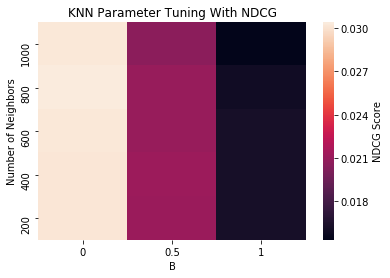

In [14]:
import seaborn as sns
from matplotlib import pyplot as plt
from pylab import savefig
sns.heatmap([[0.030248412165424784, 0.020628543351635963, 0.015338590826452843],
 [0.03039990425437948, 0.021040444216330566, 0.01599971681479519],
 [0.030257073590380705, 0.02103328664718751, 0.01623323845397321],
 [0.030176824885165376, 0.021170293828766486, 0.01623664785219119],
 [0.03021486256129421, 0.02115203783681953, 0.016243085508627544]], 
            yticklabels=['1000', '800', '600', '400', '200'], 
            xticklabels=[0,0.5,1],
            cbar_kws={'label': 'NDCG Score'})
plt.xlabel('B')
plt.ylabel('Number of Neighbors')
plt.title('KNN Parameter Tuning With NDCG')
savefig('knn_heatmap.png')

In [2]:
ndcg_by_k = [heatmap_list[2][0][0], heatmap_list[2][1][0], heatmap_list[2][2][0], heatmap_list[2][3][0], heatmap_list[2][4][0]]
plot_df = pd.DataFrame({'K':[200,400,600,800,1000],
                       'NDCG': ndcg_by_k})
g = sns.pointplot(x='K', y='NDCG', data=plot_df)
plt.show()

NameError: name 'heatmap_list' is not defined

In [12]:
def get_users(df, n):
    sample_userid = df["user_id"].unique()
    sample_userid = np.random.choice(sample_userid, size = n, replace = False)

    #grab rows with sample user id
    df_sample = df[df.user_id.isin(sample_userid)].reset_index(drop = True)

    return df_sample

In [13]:
files9k = pd.read_csv('lastfm_9000_users.csv', na_filter=False)
files20k = pd.read_csv('lastfm_20k_users.csv', na_filter=False)
files60k = pd.read_csv('lastfm_60k_users.csv', na_filter=False)

files150k = pd.read_csv('lastfm_150k_users.csv', na_filter=False)
files40k = get_users(files150k, 40000)
files = [files9k, files20k, files40k, files60k]

In [29]:
size = [9000, 20000, 40000, 60000]
ndcg_size = []
recall_size = []
for i in files:
    model = implicit.als.AlternatingLeastSquares(factors=30, regularization=0.01)

    #create sparse matrix
    plays_sparse = create_sparse_matrix(i).astype('float')

    #filter out users with < 15 artists/reduce sparsity if needed
    print('Matrix Sparsity:', calculate_sparsity(plays_sparse))

    train, test, user_count = split_train_test_per_user(plays_sparse, 4, 20)

    # train model 
    print("Fitting model...")
    model.fit(train, show_progress=True)

    recall, ndcg = evaluate(model, test, plays_sparse)
    print("Recall:",recall*100,'%')
    print("Average NDCG:",ndcg*100,'%')
    recall_size.append(recall)
    ndcg_size.append(ndcg)

Creating sparse matrix...


C:\Users\Fernando\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
C:\Users\Fernando\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


Matrix Sparsity: 99.8965986346416



Fitting model...


100%|████████████████████████████████████████████████████████████████████████████████| 15.0/15 [00:01<00:00,  8.17it/s]


Evaluating model...



Recall: 18.085416433135297 %
Average NDCG: 11.83771423725349 %
Creating sparse matrix...
Matrix Sparsity: 99.92562878672553



Fitting model...


100%|████████████████████████████████████████████████████████████████████████████████| 15.0/15 [00:03<00:00,  4.38it/s]


Evaluating model...



Recall: 18.961850526634077 %
Average NDCG: 12.21785533080523 %
Creating sparse matrix...
Matrix Sparsity: 99.94346935289622



Fitting model...


100%|████████████████████████████████████████████████████████████████████████████████| 15.0/15 [00:06<00:00,  2.40it/s]


Evaluating model...



Recall: 19.28754975563057 %
Average NDCG: 12.469762965068165 %
Creating sparse matrix...
Matrix Sparsity: 99.95028412538602



Fitting model...


100%|████████████████████████████████████████████████████████████████████████████████| 15.0/15 [00:09<00:00,  1.56it/s]


Evaluating model...



Recall: 19.66164339835022 %
Average NDCG: 12.766986057784935 %


In [31]:
ndcg_size

[0.1183771423725349,
 0.1221785533080523,
 0.12469762965068165,
 0.12766986057784935]

In [32]:
recall_size

[0.18085416433135298,
 0.18961850526634078,
 0.19287549755630573,
 0.19661643398350218]

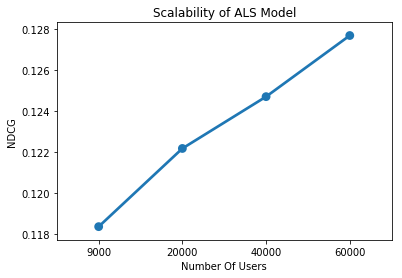

In [38]:
import seaborn as sns
from matplotlib import pyplot as plt
from pylab import savefig
ndcg_size_df = pd.DataFrame({'N':size,
                       'NDCG': ndcg_size})
g = sns.pointplot(x='N', y='NDCG', data=ndcg_size_df)
plt.title('Scalability of ALS Model')
plt.xlabel('Number Of Users')
savefig('ndcg_size.png')

In [24]:
model = implicit.nearest_neighbours.BM25Recommender(K=400, K1=1.2, 
                                                    B=0)
train, test, user_count = split_train_test_per_user(plays_sparse, 4, 20)
model.fit(train, show_progress=True)
recall, ndcg = evaluate(model, test, plays_sparse)
print("Recall:",recall*100,'%')
print("Average NDCG:",ndcg*100,'%')

100%|████████████████████████████████████████████████████████████████████████| 47102/47102 [00:00<00:00, 112557.93it/s]


Evaluating model...



Recall: 5.059970855285282 %
Average NDCG: 3.5353047929842347 %


In [18]:
plays_sparse.shape

(9000, 47102)

In [15]:
size = [9000, 20000, 40000, 60000]
ndcg_size_knn = []
recall_size_knn = []
for i in files:
    model = implicit.nearest_neighbours.BM25Recommender(K=30, K1=1.2, B=0)

    #create sparse matrix
    plays_sparse = create_sparse_matrix(i).astype('float')

    #filter out users with < 15 artists/reduce sparsity if needed
    print('Matrix Sparsity:', calculate_sparsity(plays_sparse))

    train, test, user_count = split_train_test_per_user(plays_sparse, 4, 20)

    # train model 
    print("Fitting model...")
    model.fit(train, show_progress=True)

    recall, ndcg = evaluate(model, test, plays_sparse)
    print("Recall:",recall*100,'%')
    print("Average NDCG:",ndcg*100,'%')
    recall_size_knn.append(recall)
    ndcg_size_knn.append(ndcg)

Creating sparse matrix...


C:\Users\Fernando\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
C:\Users\Fernando\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


Matrix Sparsity: 99.8965986346416



Fitting model...


100%|████████████████████████████████████████████████████████████████████████| 47102/47102 [00:00<00:00, 144655.53it/s]


Evaluating model...



Recall: 4.705750476403991 %
Average NDCG: 3.377648665900824 %
Creating sparse matrix...
Matrix Sparsity: 99.92562878672553



Fitting model...


100%|████████████████████████████████████████████████████████████████████████| 65690/65690 [00:00<00:00, 128016.35it/s]


Evaluating model...



Recall: 4.339061633825531 %
Average NDCG: 3.2469873214233695 %
Creating sparse matrix...
Matrix Sparsity: 99.94289725795333



Fitting model...


100%|████████████████████████████████████████████████████████████████████████| 85593/85593 [00:00<00:00, 103765.70it/s]


Evaluating model...



Recall: 3.936127342333266 %
Average NDCG: 2.8931711550281087 %
Creating sparse matrix...
Matrix Sparsity: 99.95028412538602



Fitting model...


100%|█████████████████████████████████████████████████████████████████████████| 98331/98331 [00:01<00:00, 91464.02it/s]


Evaluating model...



Recall: 3.551568301328898 %
Average NDCG: 2.648454589614852 %


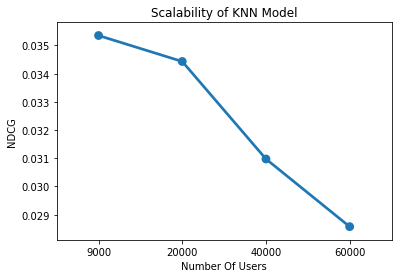

In [40]:
import seaborn as sns
from matplotlib import pyplot as plt
from pylab import savefig
ndcg_size_knn_df = pd.DataFrame({'N':size,
                       'NDCG': ndcg_size_knn})
g = sns.pointplot(x='N', y='NDCG', data=ndcg_size_knn_df)
plt.title('Scalability of KNN Model')
plt.xlabel('Number Of Users')
savefig('ndcg_size_knn.png')

## Evaluate KNN 

In [312]:
#Evaluate KNN from Cross Validation 

# train model
recall_list=[]
ndcg_list=[]
for i in range(k):
    print("Fitting model...")
    train=train_list[i]
    test=test_list[i]
    model = implicit.nearest_neighbours.BM25Recommender()    
    model.fit(train, show_progress=False)
    recall,ndcg = evaluate(model,test,plays_sparse)
    print(recall*100,'%')
    print(ndcg*100,'%')
    recall_list.append(recall)
    ndcg_list.append(ndcg)
    print("---------------------------")
print("The mean recall is ", np.mean(recall_list))
print("The mean ndcg is ", np.mean(ndcg_list))

Fitting model...
Evaluating model...


2.5053245151888803 %
1.4131626467165959 %
---------------------------
Fitting model...
Evaluating model...


2.3315771774464746 %
1.2699540001385683 %
---------------------------
Fitting model...
Evaluating model...


2.3596009415984756 %
1.247202248727995 %
---------------------------
Fitting model...
Evaluating model...


2.4296603519784776 %
1.3183555520732735 %
---------------------------
The mean recall is  0.02406540746553077
The mean ndcg is  0.013121686119141081


# Evaluate Baseline

In [214]:
#Evaluate Model-based from Baseline

# train model
recall_list=[]
ndcg_list=[]
rec_items=baseline(20,user_items)
for i in range(k):
    print("Fitting model...")
    train=train_list[i]
    test=test_list[i]
    user_items = plays_sparse.T.tocsr()
    recall,ndcg = evaluate_base(rec_items,test,plays_sparse)
    print(recall*100,'%')
    recall_list.append(recall)
    ndcg_list.append(ndcg)
    print("---------------------------")
print("The mean recall is ", np.mean(recall_list))
print("The mean ndcg is ", np.mean(ndcg_list))

Fitting model...
Evaluating model...


6.9414863804506215 %
---------------------------
Fitting model...
Evaluating model...


6.823786571012218 %
---------------------------
Fitting model...
Evaluating model...


6.823786571012218 %
---------------------------
Fitting model...
Evaluating model...


6.700482008743415 %
---------------------------
Fitting model...
Evaluating model...


6.739715278556216 %
---------------------------
The mean recall is  0.06805851361954937
The mean ndcg is  0.04428376367102882


In [31]:
model = implicit.als.AlternatingLeastSquares(factors=30, regularization=0.01)
model.fit(plays_sparse)
users = list(df.user_id.unique())
catalog = []
for i in range(0,len(users)):
    for x,y in model.recommend(i,plays_sparse.T.tocsr(), N=20, filter_already_liked_items=True):
        if x not in catalog:
            catalog.append(x)
print('Catalog Coverage is', len(catalog)/plays_sparse.shape[1])

100%|████████████████████████████████████████████████████████████████████████████████| 15.0/15 [00:01<00:00,  8.23it/s]


Catalog Coverage is 0.11050486178930831


In [32]:
model = implicit.nearest_neighbours.BM25Recommender(K=400, K1=1.2, B=0)
model.fit(plays_sparse)
users = list(df.user_id.unique())
catalog = []
for i in range(0,len(users)):
    for x,y in model.recommend(i,plays_sparse.T.tocsr(), N=20, filter_already_liked_items=True):
        if x not in catalog:
            catalog.append(x)
print('Catalog Coverage is', len(catalog)/plays_sparse.shape[1])

100%|███████████████████████████████████████████████████████████████████████████| 9000/9000 [00:00<00:00, 40268.41it/s]


Catalog Coverage is 0.16937709651394844


In [ ]:
#AUC https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
#Primary metric: ROC-based
#calculate Precision, Recall, TPr, FPr, AUC by comparing resulting matrix to test_data
#Secondary metric: DCG

#cross_validate(data, k)
#get k-fold indices on train (mask again)
#for each different k-fold, loop through the indices, masked as train, test as not
#train model
#calculate Precision, Recall, AUC, append result to list
#return list of scores for each fold

#calculate ATOP? DCG? 